In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive

# Google 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


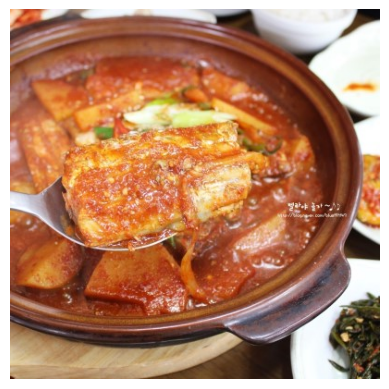

In [ ]:
#예제 이미지 확인
import matplotlib.image as mpimg
images="/content/drive/MyDrive/train"
test_image = mpimg.imread(os.path.join(images, "BoiledDown", "Img_106_0732.jpg"))
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [ ]:
class_names = ["BoiledDown(조림)", "Rice(밥)", "Noodle(면)",  "Roasted(구이)", "Kimchi(김치)"]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf

# 모델 입력 크기 (Inception v4의 경우 299x299)
image_size = (299, 299)

# 상위 디렉토리 경로 설정
train_directory = "/content/drive/MyDrive/train"

# 하위 디렉토리 리스트
subdirectories = ["BoiledDown", "Rice", "Noodle", "Roasted", "Kimchi"]

# 이미지와 레이블 데이터를 저장할 리스트 초기화
images = []
labels = []

# 각 하위 디렉토리에서 이미지 파일을 불러오기 및 전처리
for label, subdir in enumerate(subdirectories):
    subdir_path = os.path.join(train_directory, subdir)
    image_files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

    # 이미지 파일을 무작위로 섞기
    np.random.shuffle(image_files)

    # 각 클래스별로 200장의 이미지만 선택
    selected_files = image_files[:200]

    for image_file in selected_files:
        image = cv2.imread(image_file)
        if image is None:
            print(f"Error loading image: {image_file}")
            continue
        image_resized = cv2.resize(image, image_size)
        image_resized = image_resized.astype(np.float32) / 255.0  # 정규화
        images.append(image_resized)
        labels.append(label)

# 리스트를 numpy 배열로 변환
images_np = np.array(images)
labels_np = np.array(labels)

# TensorFlow 데이터셋으로 변환
dataset = tf.data.Dataset.from_tensor_slices((images_np, labels_np))

# 데이터셋을 섞고 배치 단위로 나누기
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(images_np)).batch(batch_size)

Error loading image: /content/drive/MyDrive/train/BoiledDown/Img_106_0238.jpg
Error loading image: /content/drive/MyDrive/train/BoiledDown/Img_108_0176.jpg
Error loading image: /content/drive/MyDrive/train/Roasted/Img_008_0460.jpg


In [ ]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
#inception_v3로 시도
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# 사전 학습된 Inception v3 모델 로드
base_model = InceptionV3(weights='imagenet', include_top=False)

# 새로운 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(subdirectories), activation='softmax')(x)

# 새로운 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# 사전 학습된 레이어는 학습되지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# One-hot encode the labels in the dataset
def preprocess(image, label):
    label = tf.one_hot(label, depth=5)  # Assuming 5 classes
    return image, label

dataset = dataset.map(preprocess)

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
model.fit(dataset, epochs=10)

print("Model training successful.")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 386ms/step - accuracy: 0.2951 - loss: 2.6476
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.6006 - loss: 1.0082
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.7504 - loss: 0.6774
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7730 - loss: 0.6186
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7857 - loss: 0.5647
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.7933 - loss: 0.5441
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8791 - loss: 0.3526
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9141 - loss: 0.3049
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9066 - loss: 0.2840
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9510 - loss: 0.2107
Model training successful.


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step


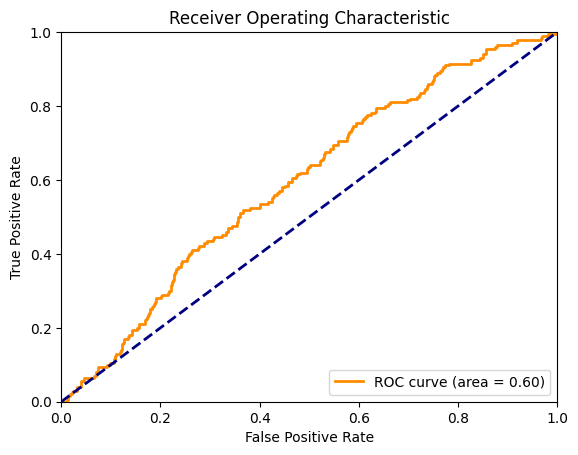

AUC Score: 0.60


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC 곡선 및 AUC 점수 계산
y_pred = model.predict(images_np)
y_pred_prob = np.max(y_pred, axis=1)
fpr, tpr, _ = roc_curve(labels_np, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.2f}")

In [ ]:
from sklearn.metrics import accuracy_score

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now calculate accuracy
accuracy = accuracy_score(labels_np, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.97
